#Configuración del ambiente

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install yfinance --upgrade --no-cache-dir

In [56]:
import pandas as pd
import numpy as np
import matplotlib as mp
import yfinance as yf

#Variables globales

In [57]:
df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision = 0

#Obtener datos

In [58]:
bitcoin = "BTC-USD"

In [59]:
df_bitcoin = yf.Ticker(bitcoin).history(interval='5m',period='7d')


In [ ]:
def importar_base_bitcoin():
  bitcoin = "BTC-USD"
  global df_bitcoin
  df_bitcoin = yf.Ticker(bitcoin).history(interval='5m',period='7d')
importar_base_bitcoin()
print(df_bitcoin)

In [60]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
import requests

In [85]:
def extraer_tendencias():

  global precio_actual, tendencia
  url = "https://coinmarketcap.com/"
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}

  respuesta = requests.get(url,headers=headers)
  soup = BeautifulSoup(respuesta.content)

  precio_actual = soup.find("div", class_='sc-a0353bbc-0 gDrtaY').get_text()
  precio_actual = float((precio_actual[1:]).replace(',',''))

  tendencia_actual = soup.find("span", class_="sc-d55c02b-0 iwhBxy")
  tendencia_actual = str(tendencia_actual)
  tendencia = 'baja'
  if 'up' in tendencia_actual: tendencia = 'alta'


extraer_tendencias()

print(f'precio_actual:{precio_actual}')
print(f'tendencia:{tendencia}')

precio_actual:43762.0
tendencia:alta


#Limpieza de datos

In [62]:
df_bitcoin_limpio = df_bitcoin.copy()


In [63]:
df_bitcoin_limpio = df_bitcoin_limpio.reset_index()


Eliminar filas con valores nulos

In [64]:
df_bitcoin_limpio = df_bitcoin_limpio.dropna()


Eliminar filas con Datetime duplicado

In [65]:
filas_repetidas = df_bitcoin_limpio.duplicated(subset='Datetime', keep=False)
df_bitcoin_limpio = df_bitcoin_limpio[~filas_repetidas]



quitar las filas con el volumen en cero

In [66]:
filtro = df_bitcoin_limpio['Volume'] == 0
df_bitcoin_limpio = df_bitcoin_limpio[~filtro]


##Quitar los outliers

In [67]:
# Calcular los límites para identificar los outliers
Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

In [68]:
condicion1 = df_bitcoin_limpio['Close'] >= limite_inferior
condicion2 = df_bitcoin_limpio['Close'] <= limite_superior
df_bitcoin_limpio = df_bitcoin_limpio[condicion1 & condicion2]


##Calcular media

In [69]:
media_bitcoin = df_bitcoin_limpio['Close'].mean()


In [88]:
def limpieza_datos():

  global media_bitcoin, df_bitcoin

  df_bitcoin_limpio = df_bitcoin.copy()
  df_bitcoin_limpio = df_bitcoin_limpio.reset_index()
  df_bitcoin_limpio = df_bitcoin_limpio.dropna()

  filas_repetidas = df_bitcoin_limpio.duplicated(subset='Datetime', keep=False)
  df_bitcoin_limpio = df_bitcoin_limpio[~filas_repetidas]

  filtro = df_bitcoin_limpio['Volume'] == 0
  df_bitcoin_limpio = df_bitcoin_limpio[~filtro]

  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR
  condicion1 = df_bitcoin_limpio['Close'] >= limite_inferior
  condicion2 = df_bitcoin_limpio['Close'] <= limite_superior
  df_bitcoin_limpio = df_bitcoin_limpio[condicion1 & condicion2]

  media_bitcoin = df_bitcoin_limpio['Close'].mean()

limpieza_datos()
print(f'media_bitcoin: {media_bitcoin}')


media_bitcoin: 42938.53424479167


#Tomar decisiones

In [89]:
def tomar_decisiones():
  global algoritmo_decision, precio_actual, media_bitcoin, tendencia
  algoritmo_decision = 'Esperar'
  if precio_actual >= media_bitcoin and tendencia == 'baja': algoritmo_decision = 'Vender'
  if precio_actual < media_bitcoin and tendencia == 'alta': algoritmo_decision = 'Comprar'



tomar_decisiones()
print(f'algoritmo_decision:{algoritmo_decision}')
print(f'precio_actual:{precio_actual}')
print(f'tendencia:{tendencia}')


decision:Esperar
precio_actual:43762.0
tendencia:alta


#Visualización

In [71]:
df_bitcoin['Promedio'] = media_bitcoin


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
plt.title('Gráfico de Bitcoin')
plt.plot(df_bitcoin_limpio['Datetime'], df_bitcoin_limpio['Close'], label='Close')
plt.axhline(y=media_bitcoin, color='r', linestyle='--', label='Promedio')
plt.text(df_bitcoin_limpio['Datetime'].iloc[-1], df_bitcoin_limpio['Close'].iloc[-1], 'Decisión:\n {}'.format(algoritmo_decision), color='r', verticalalignment='center')
plt.show()

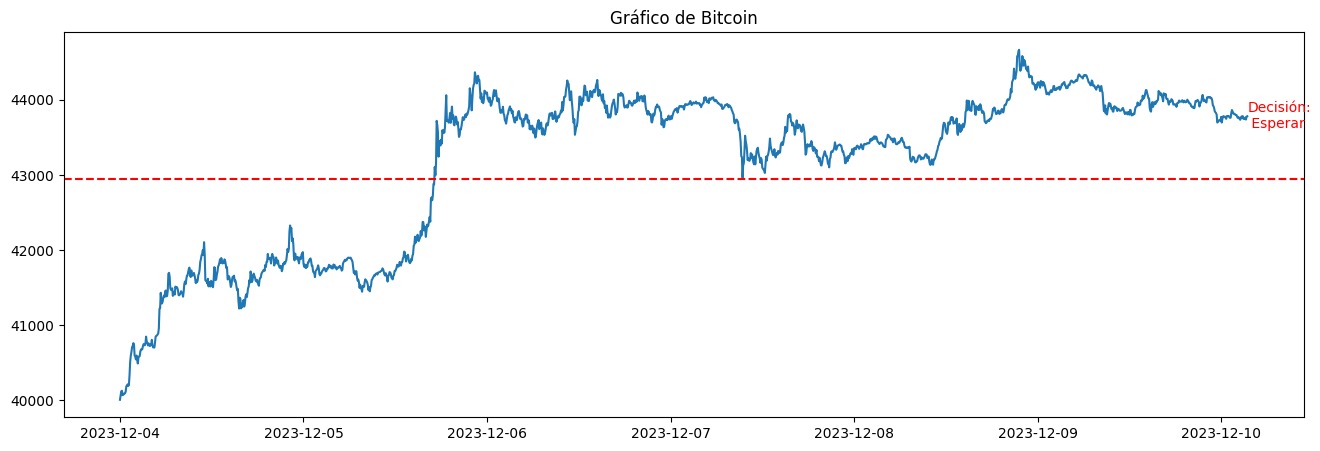

In [92]:
def visualizacion():
  global df_bitcoin, media_bitcoin, algoritmo_decision
  df_bitcoin['Promedio'] = media_bitcoin
  df_bitcoin = df_bitcoin.reset_index()
  plt.figure(figsize=(16, 5))
  plt.title('Gráfico de Bitcoin')
  plt.plot(df_bitcoin['Datetime'], df_bitcoin['Close'], label='Close')
  plt.axhline(y=media_bitcoin, color='r', linestyle='--', label='Promedio')
  plt.text(df_bitcoin['Datetime'].iloc[-1], df_bitcoin['Close'].iloc[-1], 'Decisión:\n {}'.format(algoritmo_decision), color='r', verticalalignment='center')
  plt.show()

visualizacion()

#Automatización

In [73]:
from IPython.display import clear_output
import time

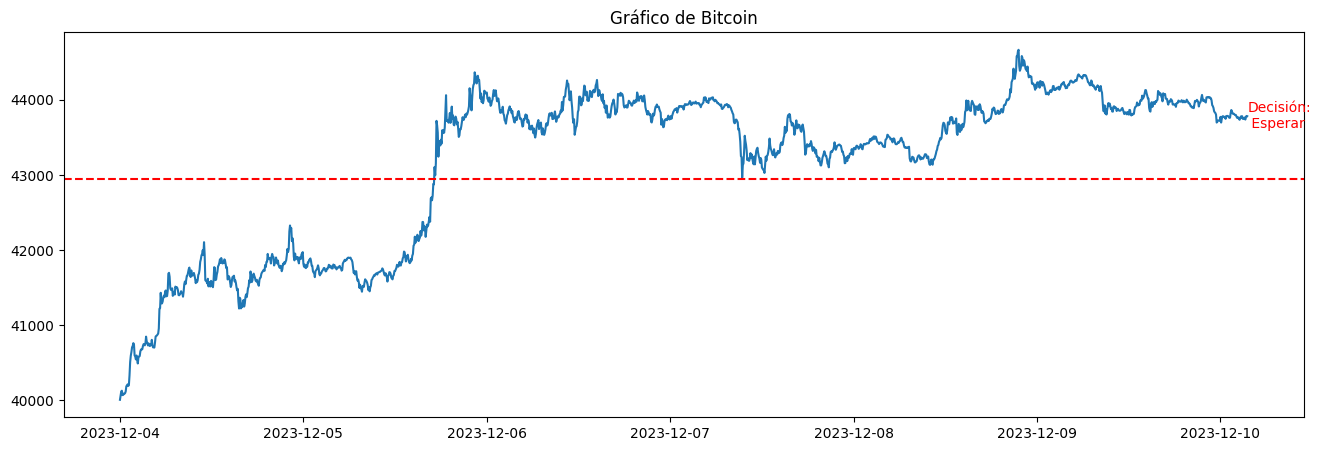

KeyboardInterrupt: ignored

In [93]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)